In [136]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm 
import pickle
import random as rd
import itertools
from scipy.stats import qmc, ttest_ind
import scipy.stats as stats


In [5]:
np.random.seed(4264327423)

### QUESTION 1

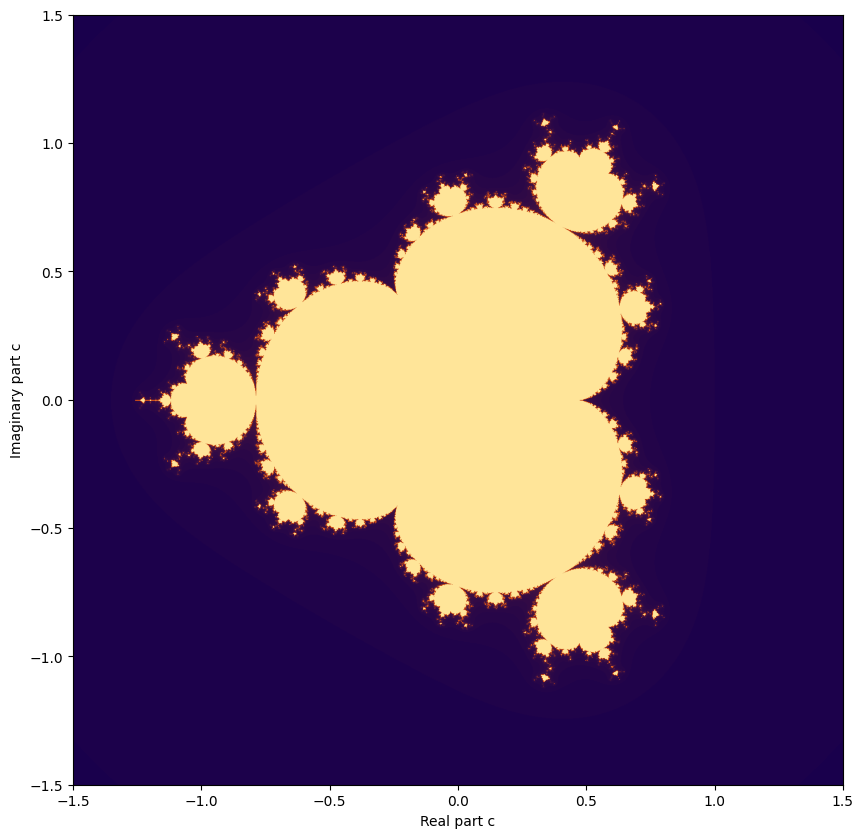

In [ ]:
# set graph size and axes 
width, height = 1500, 1500
x_min, x_max = -1.5, 1.5 # used -1.5, 1.5 for plots
y_min, y_max = -1.5, 1.5 # used -1.5, 1.5 for plots

# custom coloring 
colors = [(0.1, 0, 0.3), (0.8, 0.3, 0.1), (1, 0.9, 0.6)]    
name = "nicemap"
cmap = LinearSegmentedColormap.from_list(name, colors)

# max iterations we test for to let it escape, increase for more detail
max_iterations = 100

# empty set to store iteration counts
mandelbrot_set = np.zeros((height, width))

# Iterate over each pixel in the image
for i in range(width):
    for pixel in range(height):
        # position to complex number. complex(computes real part, computes imaginary part) 
        c = complex(x_min + (i / width) * (x_max - x_min),
                    y_min + (pixel / height) * (y_max - y_min))
        # set z at time 0 = 0 
        z = 0 
        # keep count of iterations
        iteration = 0
        
        # mandelbrot where we set a threshold that is equal to 2 and apply formula
        # change **d for m2 m3 and m4
        while abs(z) <= 2 and iteration < max_iterations:
            z = z**4 + c 
            iteration += 1
            
        # store iterations
        mandelbrot_set[pixel, i] = iteration

# plot
plt.figure(figsize=(12,10))
plt.imshow(mandelbrot_set, cmap, extent=(x_min, x_max, y_min, y_max))
# plt.colorbar(label="iterations")
plt.xlabel("Real part c")
plt.ylabel("Imaginary part c")
plt.show()

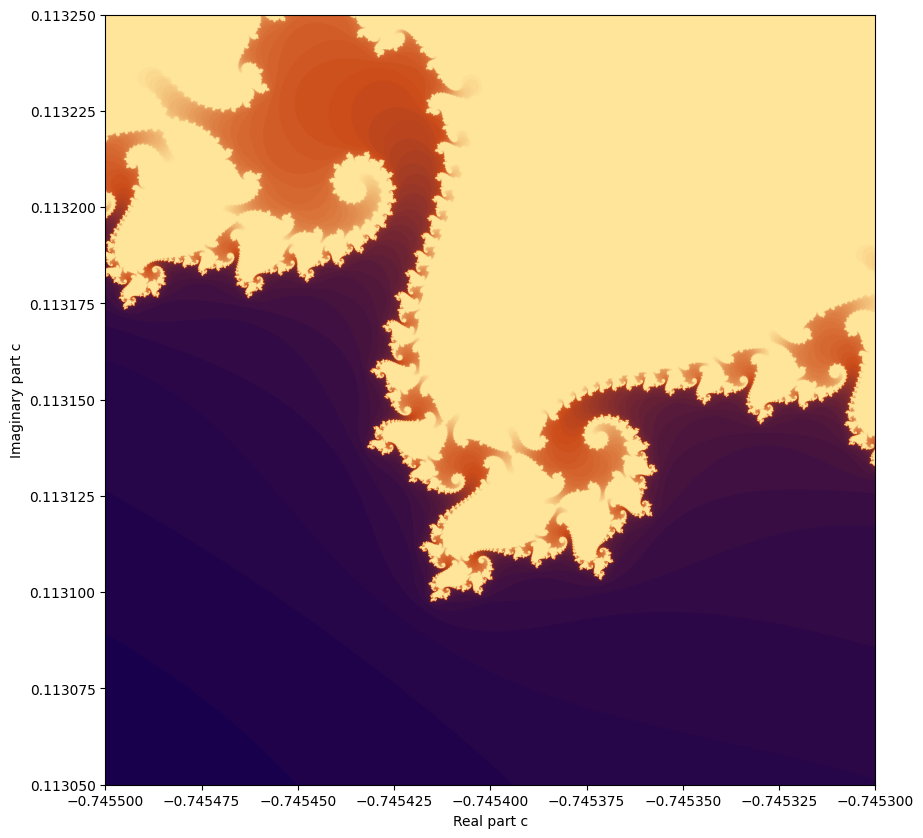

In [ ]:
# set graph size and axes
width, height = 2000, 2000
# zoom 1
# x_min, x_max = -1.405, -1.395
# y_min, y_max = -0.005, 0.005
# zoom2
x_min, x_max = -0.7455, -0.7453
y_min, y_max = 0.11305, 0.11325

# custom coloring 
colors = [(0.1, 0, 0.3), (0.8, 0.3, 0.1), (1, 0.9, 0.6)]    
name = "nicemap"
cmap = LinearSegmentedColormap.from_list(name, colors)

# max iterations we test for to let it escape, increase for more detail
max_iterations = 100

# empty set to store iteration counts
mandelbrot_set = np.zeros((height, width))

# iterate over each pixel in the image
for i in range(width):
    for pixel in range(height):
        # position to complex number. complex(computes real part, computes imaginary part) 
        c = complex(x_min + (i / width) * (x_max - x_min),
                    y_min + (pixel / height) * (y_max - y_min))
        # set z at time 0 = 0 
        z = 0 
        # keep count of iterations
        iteration = 0
        
        # mandelbrot where we set a threshold that is equal to 2 and apply formula
        while abs(z) <= 2 and iteration < max_iterations:
            z = z**2 + c 
            iteration += 1
            
        # store iterations
        mandelbrot_set[pixel, i] = iteration

# plot
plt.figure(figsize=(12,10))
plt.imshow(mandelbrot_set, cmap, extent=(x_min, x_max, y_min, y_max))
# plt.colorbar(label="iterations")
plt.xlabel("Real part c")
plt.ylabel("Imaginary part c")
plt.show()

### QUESTION 2 & 3

In [141]:
def monte_carlo(n_samples, sample_type,  n_iterations, y_min, y_max, x_min, x_max): 
    true_count = 0      

    if sample_type == "lhs": 
        points = lhs_qmc(n_samples, y_min, y_max, x_min, x_max)
    elif sample_type == "orthogonal":
        points = orthogonal_sample(n_samples, x_min, x_max, y_min, y_max)
    elif sample_type == "pure_random": 
        points = pure_radom_sample(y_min, y_max, x_min, x_max, n_samples)


    for i in range(len(points)): 
        x_coordinate, y_coordinate, complex_element = points[i][0], points[i][1], points[i][2]

        if mandel_check(complex_element, n_iterations):
            true_count +=1 

    area_total = (x_max-x_min)*(y_max-y_min)
    mandel_area = (true_count/(n_samples)) * area_total
    print(f"Estimated area for {n_samples} samples and {n_iterations} iterations: {mandel_area}")
    return mandel_area

def calculate_Am(): 
    pass 

def mandel_check(complex_number, max_iteration): 
    z = 0
    for _ in range(max_iteration): 
        z = z**2 + complex_number
        if abs(z) > 2: 
            return False
    return True

def pure_radom_sample(y_min, y_max, x_min, x_max, n_samples):
    """
    Pure random sampling
    """
    samples = [] 
    for _ in range(n_samples): 
        x_coordinate = rd.uniform(x_min, x_max)
        y_coordinate  = rd.uniform(y_min, y_max)
        complex_element = complex(x_coordinate,y_coordinate)
        samples.append([x_coordinate, y_coordinate, complex_element])

    return samples


def lhs_qmc(n_samples, y_min, y_max, x_min, x_max):
    """
    Latin hypercube sampling
    """
    sampler = qmc.LatinHypercube(d=2)  

    # generate  samples
    lhs_samples = sampler.random(n=n_samples)

    # Rescale 
    x_coordinates_rescaled = x_min + (x_max - x_min) * lhs_samples[:, 0]
    y_coordinates_rescaled = y_min + (y_max - y_min) * lhs_samples[:, 1]
    complex_elements = x_coordinates_rescaled + 1j * y_coordinates_rescaled

    # Combine
    samples = np.column_stack((x_coordinates_rescaled, y_coordinates_rescaled, complex_elements)).tolist()
    
    return samples
 

def orthogonal_sample(n_samples, x_min, x_max, y_min, y_max): 
    """
    Orthogonal sampling
    """
    samples = [] 

    # create two squares
    xlist = np.arange(1,n_samples + 1).reshape(int(np.sqrt(n_samples)),int(np.sqrt(n_samples)))
    ylist = np.arange(1,n_samples + 1).reshape(int(np.sqrt(n_samples)),int(np.sqrt(n_samples)))

    # permutate rows
    for i in range(int(np.sqrt(n_samples))):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])
    
    # scale and create random
    for i in range(int(np.sqrt(n_samples))):
        for j in range(int(np.sqrt(n_samples))):
            x_coordinate = (np.abs(x_max-x_min) / n_samples) * (xlist[i][j] + np.random.rand())
            y_coordinate = (np.abs(y_max-y_min) / n_samples) * (ylist[i][j] + np.random.rand())
            complex_element = complex(x_coordinate, y_coordinate)
            samples.append([x_coordinate, y_coordinate, complex_element])


    return samples


In [185]:
# set sampling algorithm
sample_types = ["pure_random", "orthogonal", "lhs"]  # alternitive: "pure_random", "orthogonal" 
# set number of iterations
n_it = [1, 10, 100, 1000, 10000, 100000, 100000, 1000000] 

# set sample size
n_sample = [10, 100, 100, 1000, 10000, 100000, 1000000, 1000000]

### TEMPORARY SETTING
# set number of iterations
n_it = [100]
# set sample size
n_samples = [100,400,900,1600,2500,3600,4900]


# complex plain boundaries: y_min, y_max
x_min, x_max = -2, 2
y_min, y_max = -2, 2

# for loop for keeping iterations constant
for sample_type in sample_types:
      for n_sample in n_samples: 
            with open(f"{sample_type}_with_{n_it[0]}_iterations_and_{n_sample}_samples.pkl", "wb") as f:
                        for _ in range(50):
                              result = monte_carlo(n_sample,sample_type, n_it[0],  y_min, y_max, x_min, x_max)
                              pickle.dump(result, f)

# for loop for keeping number of samples constant

Estimated area for 100 samples and 100 iterations: 1.92
Estimated area for 100 samples and 100 iterations: 0.8
Estimated area for 100 samples and 100 iterations: 1.92
Estimated area for 100 samples and 100 iterations: 1.28
Estimated area for 100 samples and 100 iterations: 2.08
Estimated area for 100 samples and 100 iterations: 1.28
Estimated area for 100 samples and 100 iterations: 2.08
Estimated area for 100 samples and 100 iterations: 0.8
Estimated area for 100 samples and 100 iterations: 1.6
Estimated area for 100 samples and 100 iterations: 1.92
Estimated area for 100 samples and 100 iterations: 1.92
Estimated area for 100 samples and 100 iterations: 1.92
Estimated area for 100 samples and 100 iterations: 1.6
Estimated area for 100 samples and 100 iterations: 1.12
Estimated area for 100 samples and 100 iterations: 1.6
Estimated area for 100 samples and 100 iterations: 1.76
Estimated area for 100 samples and 100 iterations: 1.6
Estimated area for 100 samples and 100 iterations: 0.9

### Load data

In [186]:
confidence_level = 0.95

# dictionary for all data
results_by_sample_type = {}

for sample_type in sample_types:
    all_results = []
    for n_sample in n_samples:
        results = []
        with open(f"{sample_type}_with_{n_it[0]}_iterations_and_{n_sample}_samples.pkl", "rb") as f:
            try:
                while True:
                    result = pickle.load(f)
                    results.append(result)
            except EOFError: 
                pass  
        results = np.array(results)
        mean = np.mean(results, axis=0)

        std_err = stats.sem(results, axis=0) 
        h = std_err * stats.t.ppf((1 + confidence_level) / 2., len(results) - 1)
        lower_bound = mean - h
        upper_bound = mean + h

        all_results.append((n_sample, mean, lower_bound, upper_bound))
    
    results_by_sample_type[sample_type] = all_results
print(len(results_by_sample_type[sample_type]))
print((results_by_sample_type[sample_type]))

7
[(100, 1.4912, 1.3959775812848274, 1.5864224187151728), (400, 1.5456, 1.5078089925047637, 1.5833910074952364), (900, 1.5502222222222224, 1.519160953366166, 1.5812834910782787), (1600, 1.5620000000000003, 1.531830408522381, 1.5921695914776195), (2500, 1.5310080000000001, 1.50793572155243, 1.5540802784475702), (3600, 1.5422222222222224, 1.5244800401750789, 1.559964404269366), (4900, 1.550955102040816, 1.5341584408026694, 1.5677517632789628)]


### Plot data

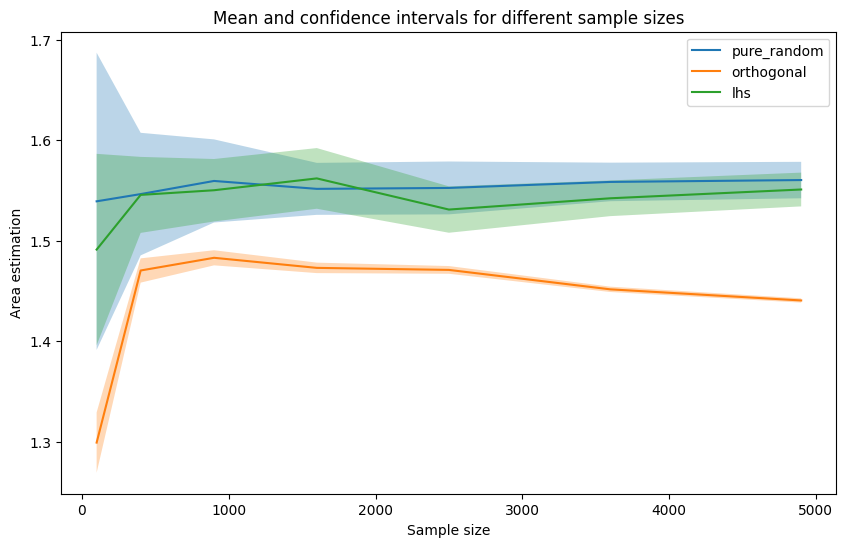

In [ ]:
n_samples = [100, 400, 900, 1600, 2500, 3600, 4900]

plt.figure(figsize=(10, 6))
for sample_type, data in results_by_sample_type.items():
    means = []
    lower_bounds = []
    upper_bounds = []
    for n_sample, mean, lower_bound, upper_bound in data:
        means.append(mean)
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)
    plt.plot(n_samples, means, label=f'{sample_type}')
    plt.fill_between(n_samples, lower_bounds, upper_bounds, alpha=0.3)

plt.xlabel("Sample size")
plt.ylabel("Area estimation")
plt.title("Mean and confidence intervals for different sample sizes and 100 iterations")
plt.legend()
plt.show()

TypeError: 'int' object is not subscriptable

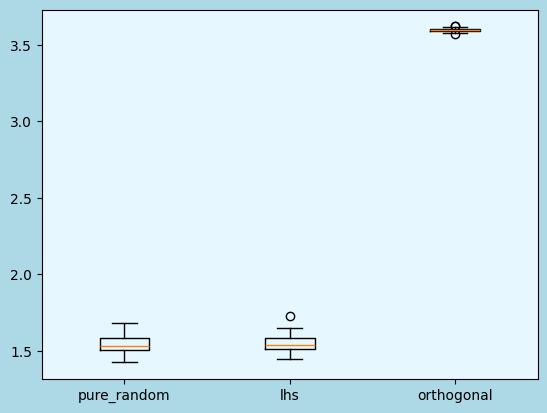

In [ ]:
#### DONT DELETE THIS ####

all_results = []
sample_types = ["pure_random","lhs", "orthogonal"]
for sample_type in sample_types:
    with open(f"{sample_type}_with_{n_it[0]}_iterations_and_{n_sample}_samples.pkl", "rb") as f:
        results = []
        try:
            while True:
                results.append(pickle.load(f))
        except EOFError:
            all_results.append(results)
            pass

fig, ax = plt.subplots()
ax.set_facecolor("#e6f7ff")  
fig.set_facecolor("lightblue")

ax.boxplot(all_results, labels=sample_types)
ax.set_title(f"estimations using {n_it[0]} iterations and {n_sample[0]} samples")
ax.set_ylabel('Area estimations')



# ttest
t_stat, p_value = ttest_ind(all_results[0], all_results[1])
print("T-statistic:", t_stat)
print("P-value:", p_value)
alpha = 0.05
if p_value < alpha:
    print("Reject h0. Means are significantly different.")
else:
    print("Fail to reject h0. Means are not significantly different.")

# todo:
# - confidence intervals
# - ttests 
# - ftests 
# confidence interval size over sample size with 3 methods in one plot.

### DONT DELETE THIS ###






### Iteration Runs ###

Calculating for i = 1000 iterations: 100%|██████████| 200/200 [00:00<00:00, 231.91it/s]


mean area estimate for i = 1.53315


Calculating for 1000 iterations: 100%|██████████| 200/200 [00:00<00:00, 236.63it/s]


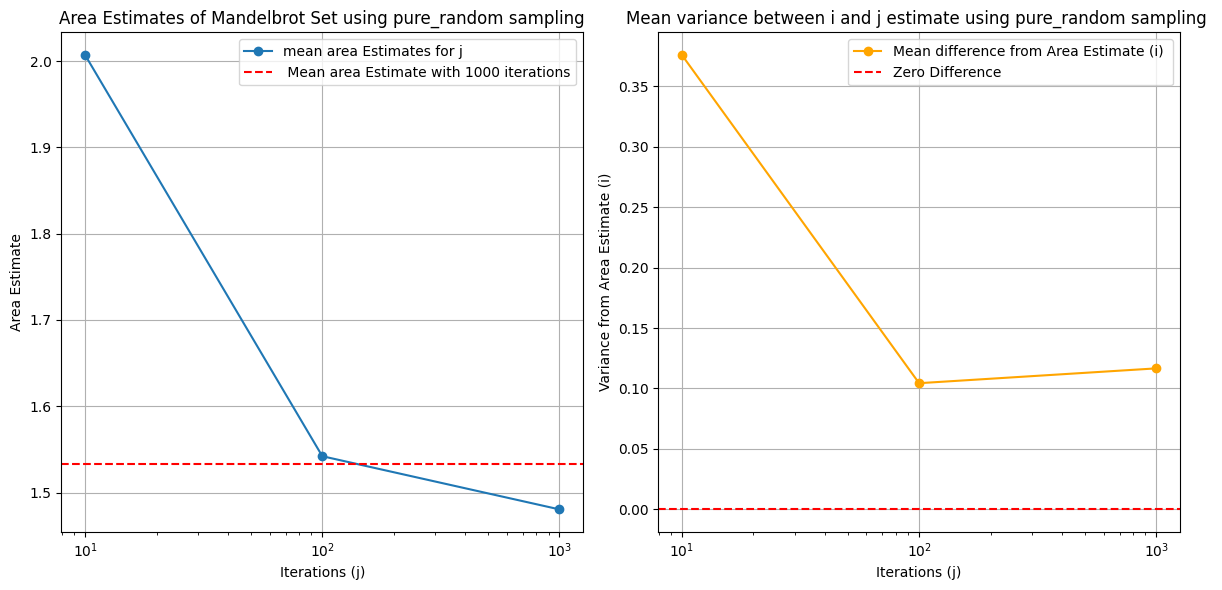

In [ ]:


n_runs = 200
samples = 100
i = 1000000
j = [10, 100, 1000, 10000, 100000]# 1000, 10000,100000,1000000] 


def iteration_plot(i, j, samples, sample_type, n_runs): 

    j_estimates = np.zeros(( n_runs, len(j)))
    
    plt.figure(figsize=(12, 6))
    i_estimate = []
    #Get baseline
    for run in tqdm(range(n_runs), desc= f"Calculating for i = {i} iterations"): 
        area_run_i = monte_carlo(samples, sample_type, i, y_min, y_max, x_min, x_max)
        i_estimate.append(area_run_i)
    area_estimate_i = np.mean(i_estimate)
    print(f"mean area estimate for i = {area_estimate_i}")
        


    for setting in range(len(j)): 
        
        for  run in tqdm(range(n_runs), desc= f"Calculating for {j[setting]} iterations"):   
                     
            area_setting_j  = monte_carlo(samples,sample_type, j[setting], y_min, y_max, x_min, x_max)
            j_estimates[run][setting] = area_setting_j
            
        
       
    mean_area = np.mean(j_estimates, axis=0)
    mean_differences = np.mean(np.square(j_estimates - area_estimate_i), axis=0)


    #  j
    plt.subplot(1, 2, 1)
    plt.plot(j, mean_area, marker='o', label=f'mean area Estimates for j')       
    plt.axhline(y=area_estimate_i, color='r', linestyle='--', label=f' Mean area Estimate with {i} iterations')
    plt.title(f'Area Estimates of Mandelbrot Set using {sample_type} sampling')
    plt.xlabel('Iterations (j)')
    plt.xscale("log")
    plt.ylabel('Area Estimate')
    plt.legend()
    plt.grid(True)

    # differences
    plt.subplot(1, 2, 2)
    plt.plot(j, mean_differences, marker='o', color='orange', label=f'Mean difference from Area Estimate (i) ')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Difference')
    plt.title(f'Mean variance between i and j estimate using {sample_type} sampling ')
    plt.xlabel('Iterations (j)')
    plt.xscale("log")

    plt.ylabel('Variance from Area Estimate (i)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    
        


iteration_plot(i, j, samples, "pure_random", n_runs)



Calculating for i = 1000 iterations: 100%|██████████| 200/200 [00:00<00:00, 233.14it/s]


mean area estimate for i = 1.4917500000000001


Calculating for 1000 iterations: 100%|██████████| 200/200 [00:00<00:00, 244.40it/s]


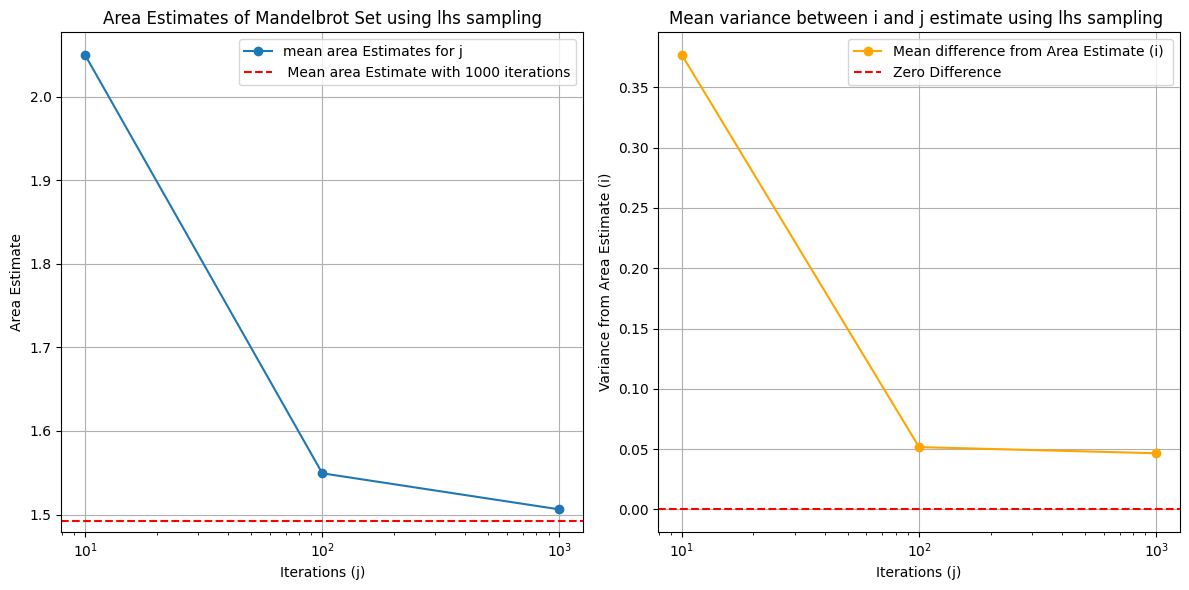

In [221]:
iteration_plot(i, j , samples, "lhs", n_runs )


Calculating for i = 1000 iterations: 100%|██████████| 200/200 [00:00<00:00, 222.86it/s]


mean area estimate for i = 1.44


Calculating for 1000 iterations: 100%|██████████| 200/200 [00:00<00:00, 241.25it/s]


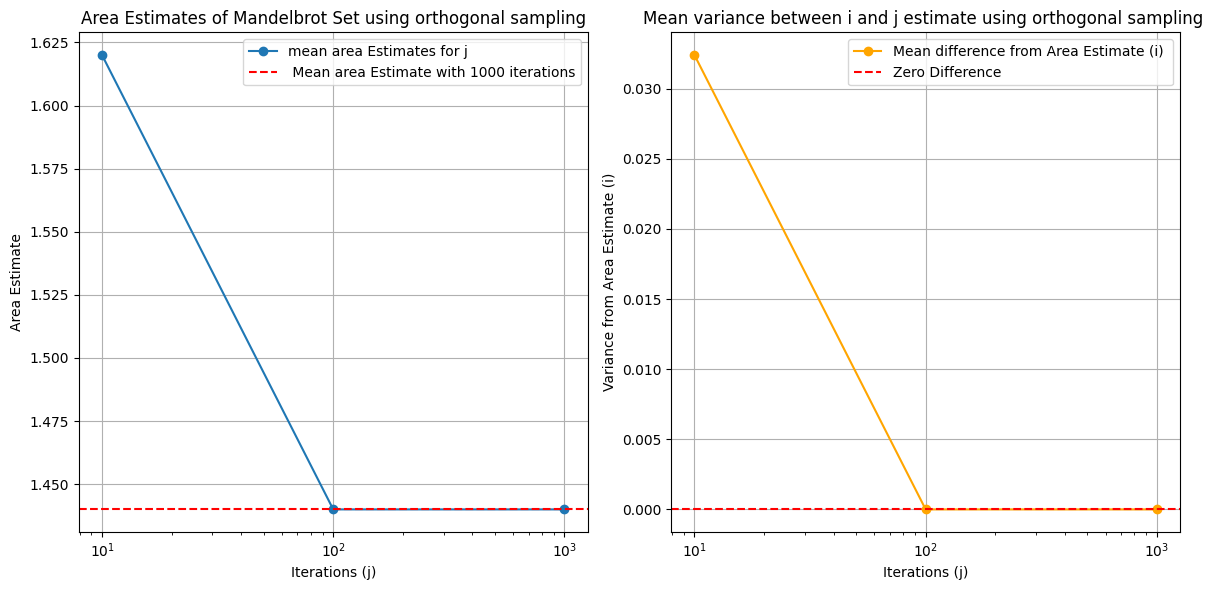

In [222]:
iteration_plot(i, j, samples, "orthogonal", n_runs)

### Sample Runs ###


In [226]:

def compute_variance(area_setimate_i, area_estimate_j):
    squared_difference = (area_estimate_j-area_setimate_i) ** 2
    return squared_difference 

     

n_runs = 200
n_iterations = 100
i = 1000000
j = [10, 100, 1000, 10000, 100000] 


def sample_plot(i, j, n_iterations, sample_type, n_runs): 

    j_estimates = np.zeros(( n_runs, len(j)))
    differences = np.zeros(( n_runs, len(j)))
    
    plt.figure(figsize=(12, 6))
    i_estimate = []
    for run in tqdm(range(n_runs), desc= f"Calculating for i = {i} samples"): 
        area_run_i = monte_carlo(i, sample_type, n_iterations, y_min, y_max, x_min, x_max)
        i_estimate.append(area_run_i)
    area_estimate_i = np.mean(i_estimate)
    print(f"mean area estimate for i = {i} samples: {area_estimate_i}")
        


    for setting in range(len(j)): 
        
        for  run in tqdm(range(n_runs), desc= f"Calculating for {j[setting]} samples"):   
                     
            area_setting_j  = monte_carlo(j[setting],sample_type, n_iterations, y_min, y_max, x_min, x_max)
            variance = compute_variance(area_estimate_i, area_setting_j)

            #differences[run][setting]= variance
            j_estimates[run][setting] = area_setting_j
        
            
        
       
    mean_area = np.mean(j_estimates, axis=0)
    #mean_differences = np.mean(differences, axis = 0 )
    mean_differences = np.mean(np.square(j_estimates - area_estimate_i), axis=0)

    #  j
    plt.subplot(1, 2, 1)
    plt.plot(j, mean_area, marker='o', label=f'mean area Estimates for j')       
    plt.axhline(y=area_estimate_i, color='r', linestyle='--', label=f' Mean area Estimate with {i} samples')
    plt.title(f'Area Estimates of Mandelbrot Set using {sample_type} sampling')
    plt.xlabel('Samples (j)')
    plt.xscale("log")
    plt.ylabel('Area Estimate')
    plt.legend()
    plt.grid(True)

    # differences
    plt.subplot(1, 2, 2)
    plt.plot(j, mean_differences, marker='o', color='orange', label=f'Mean difference from Area Estimate (i) ')
    plt.axhline(y=0, color='r', linestyle='--', label='Zero Difference')
    plt.title(f'Mean variance between i and j estimate using {sample_type} sampling ')
    plt.xlabel('Samples (j)')
    plt.xscale("log")

    plt.ylabel('Variance from Area Estimate (i)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    
        


sample_plot(i, j, n_iterations, "pure_random", n_runs)



Calculating for i = 1000000 samples:   2%|▏         | 4/200 [00:29<23:53,  7.31s/it]


KeyboardInterrupt: 

<Figure size 1200x600 with 0 Axes>

Calculating for i = 10000 samples: 100%|██████████| 200/200 [00:11<00:00, 16.71it/s]


mean area estimate for i = 10000 samples: 1.5462765000000003


Calculating for 1000 samples: 100%|██████████| 200/200 [00:01<00:00, 168.24it/s]


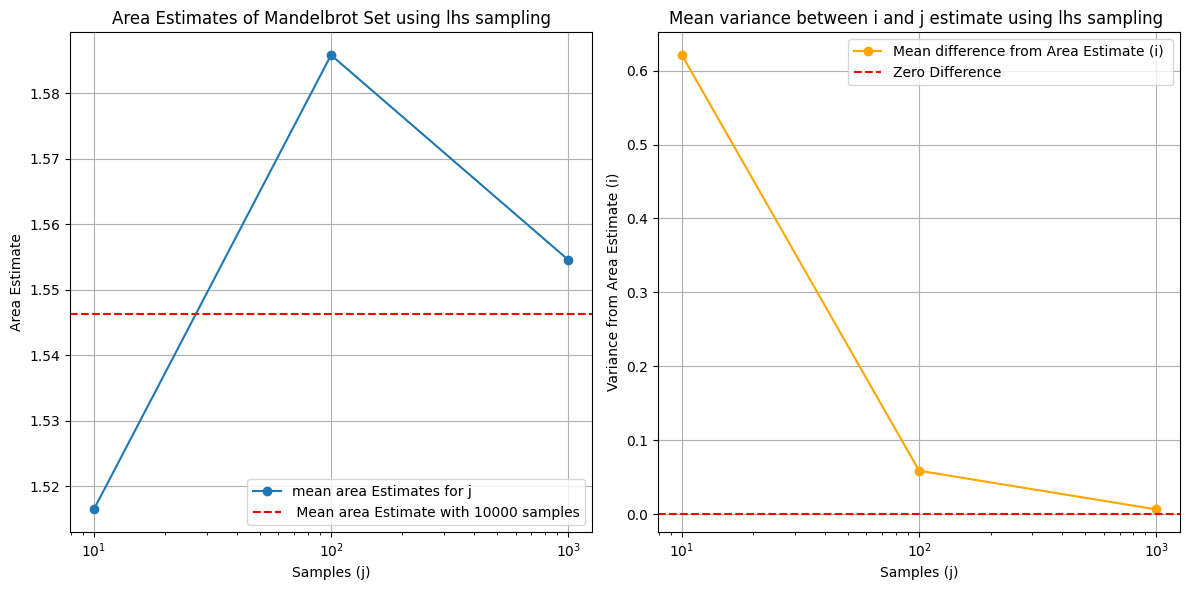

In [214]:
sample_plot(i, j, n_iterations, "lhs", n_runs)


Calculating for i = 10000 samples: 100%|██████████| 200/200 [00:13<00:00, 14.41it/s]


mean area estimate for i = 10000 samples: 1.5138


Calculating for 1000 samples: 100%|██████████| 200/200 [00:01<00:00, 169.91it/s]


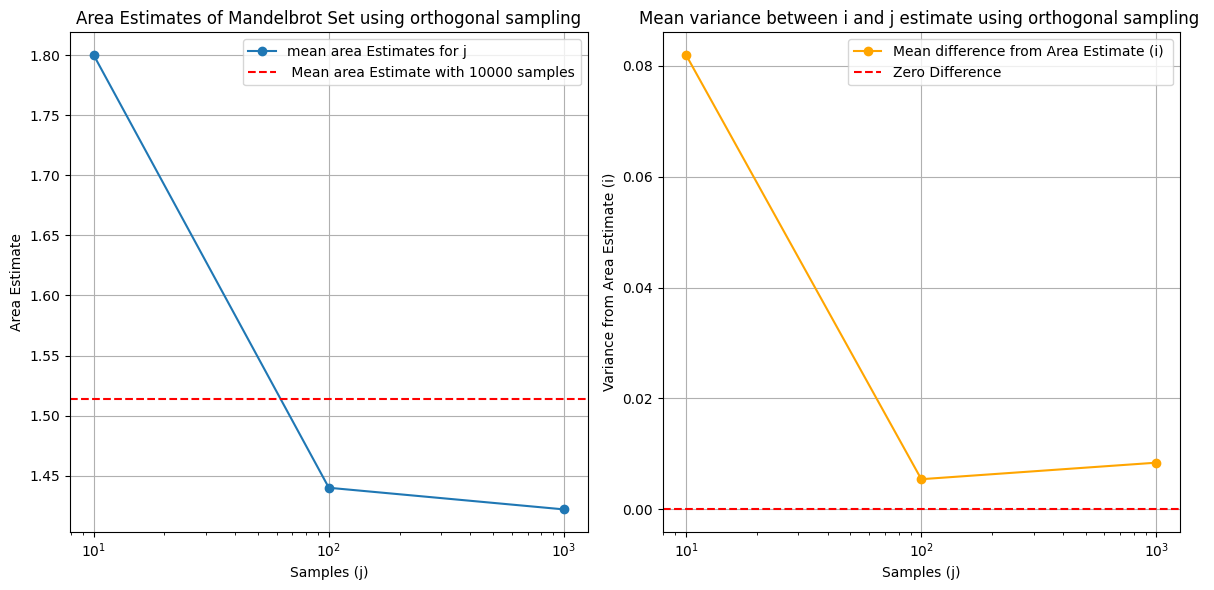

In [216]:
sample_plot(i, j, n_iterations, "orthogonal", n_runs)
